In [79]:
import pickle
from ultralytics import YOLO

from keyrover import *
from keyrover.vision import *
from keyrover.images.texcoord import *
from keyrover.images.key_mask import *
from keyrover.color import NamedPalette
from keyrover.vision.models import CornersRegressionModel
from keyrover.datasets import KeyboardCornersDataset

In [80]:
SIZE = (256, 256)

dataset = "v4-nodistort"
test_dataset = KeyboardCornersDataset([], size=SIZE, version=dataset)

0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [81]:
model = CornersRegressionModel.load("magic-wave-28.pt")
model.to(device)
model.eval()

yolo = YOLO("models/yolo/train4/weights/best.pt")


image 1/1 /Users/bhavyemathur/Desktop/Academics/College/UMich/MRover/keyboard-detection/keyrover/../datasets/test/image/a0.png: 256x320 47 keys, 27.6ms
Speed: 2.7ms preprocess, 27.6ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 320)
<class 'numpy.ndarray'> (float32, shape=(480, 640, 3))
        Min: 0.0
        Max: 1.0
        Mean: 0.3732954263687134


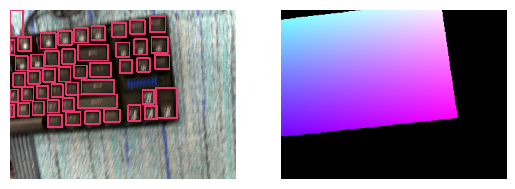

In [214]:
path = f"{DATASETS}/test/image/a0.png"
img = test_dataset.load_image(path)

# TODO yolo & model to use same input image size

bboxes = yolo.predict(path, conf=0.5, iou=0.3)[0]
mask = model.predict(img)
mask = cv2.resize(mask, bboxes.orig_shape[::-1])

out = plot_yolo(bboxes, draw_text=False, plot=False)
imshow(out, mask)

describe(mask)

In [197]:
keys = keys_from_yolo(bboxes)
texcoords = TexcoordImage(mask * 255, keys)

In [198]:
with open(f"{DATASETS}/texcoords/{dataset}/texcoords_palette.bin", "rb") as file:
    palette: NamedPalette = pickle.load(file)

palette.colors

array([[ 43,  27],
       [ 91,  32],
       [139,  27],
       [157,  27],
       [175,  27],
       [193,  27],
       [215,  27],
       [ 48,  66],
       [ 62,  66],
       [228,  27],
       [ 75,  66],
       [241,  27],
       [ 89,  66],
       [103,  66],
       [117,  66],
       [130,  66],
       [144,  66],
       [158,  66],
       [ 41, 107],
       [183,  67],
       [ 54, 107],
       [229,  66],
       [ 68, 107],
       [ 82, 107],
       [ 96, 107],
       [110, 107],
       [124, 107],
       [137, 107],
       [151, 107],
       [ 37, 148],
       [165, 107],
       [ 51, 148],
       [ 65, 148],
       [186, 107],
       [ 78, 148],
       [ 92, 148],
       [106, 148],
       [120, 148],
       [134, 148],
       [ 46, 187],
       [147, 148],
       [161, 148],
       [ 60, 187],
       [175, 148],
       [ 73, 187],
       [192, 148],
       [ 87, 187],
       [228, 151],
       [214, 151],
       [241, 151],
       [101, 187],
       [115, 187],
       [128,

In [199]:
source = np.array(list(texcoords.texcoords.values()))
source

array([[     186.87,      157.01],
       [     242.21,       204.5],
       [     226.87,      117.91],
       [      212.6,      118.78],
       [     241.43,      157.32],
       [     225.68,      157.93],
       [     241.92,      119.83],
       [     188.57,      82.495],
       [     192.16,      199.07],
       [     177.85,      198.76],
       [     197.76,      20.687],
       [     228.22,      18.243],
       [      215.3,      21.132],
       [     225.33,      202.64],
       [     191.74,      118.19],
       [     210.05,      201.46],
       [     182.52,      21.001],
       [     166.11,      154.75],
       [     175.28,      118.53],
       [     163.78,      197.55],
       [     167.94,      84.776],
       [     211.08,      156.18],
       [     140.24,      152.05],
       [     167.39,      23.042],
       [     137.15,      117.26],
       [     163.91,      53.495],
       [      162.5,      117.38],
       [     153.12,      22.703],
       [     143.81,

In [200]:
def create_distance_matrix(A, B):
    A = np.repeat(A[:, None, :], len(B), axis=1)
    return np.linalg.norm(A - B, axis=-1)

n = len(source)
m = len(palette.colors)

# source (n, 2)-vector of points in 2D
# palette (m, 2)-vector of points in 2D
# dist_matrix (n, m) matrix of pairwise distance between source & palette
distance_matrix = create_distance_matrix(source, palette.colors)
distance_matrix

array([[     193.91,      157.53,      138.54, ...,      171.51,      184.32,      195.97],
       [     266.82,      229.39,      205.33, ...,       224.9,      237.86,      238.58],
       [     205.11,      160.75,      126.43, ...,         220,      232.38,      248.58],
       ...,
       [     186.05,       137.8,      91.591, ...,      250.24,      261.23,      286.09],
       [     80.028,      34.517,      32.279, ...,      168.33,      176.43,       211.1],
       [     220.84,      203.43,      206.57, ...,      114.39,      126.41,       117.8]], dtype=float32)

In [201]:
# ith row is the ith source point
# jth column is weight between source and jth target point

distance_cost_matrix = 1e6 / (distance_matrix ** 3)
distance_cost_matrix

array([[    0.13716,     0.25579,     0.37609, ...,     0.19821,     0.15968,     0.13287],
       [   0.052645,    0.082844,     0.11552, ...,    0.087914,    0.074309,    0.073636],
       [    0.11588,     0.24075,     0.49482, ...,    0.093914,    0.079692,    0.065105],
       ...,
       [    0.15529,     0.38215,      1.3015, ...,    0.063815,    0.056098,    0.042707],
       [     1.9511,      24.317,      29.732, ...,     0.20965,     0.18207,      0.1063],
       [   0.092843,     0.11878,     0.11344, ...,     0.66801,     0.49508,     0.61168]], dtype=float32)

In [202]:
# 0 - weight between 1st source & 1st target (W11)
# 1 - weight between 1st source & 2nd target (W12)
# m - weight between 1st source & mth target (W1m)
# ...
W = distance_cost_matrix.flatten()
W = np.tile(W, 2)

print(W.shape)
W

(8178,)


array([    0.13716,     0.25579,     0.37609, ...,     0.66801,     0.49508,     0.61168], dtype=float32)

In [203]:
targets = np.tile(palette.colors, (n, 1))
targets = targets.flatten(order="F") * W

print(targets.shape)
targets

(8178,)


array([     5.8979,      23.277,      52.277, ...,      124.92,       92.58,      140.69], dtype=float32)

In [204]:
ones = np.ones((n * m, 1))
zeros = np.zeros((n * m, 1))

repeated_source = np.repeat(source, m, axis=0)

P1 = np.hstack([repeated_source, zeros, zeros, ones, zeros])
P2 = np.hstack([zeros, zeros, repeated_source, zeros, ones])
P = np.vstack([P1, P2]) * W[:, None]
P

array([[     25.631,      21.535,           0,           0,     0.13716,           0],
       [     47.798,       40.16,           0,           0,     0.25579,           0],
       [     70.279,      59.049,           0,           0,     0.37609,           0],
       ...,
       [          0,           0,       82.01,       155.6,           0,     0.66801],
       [          0,           0,      60.779,      115.32,           0,     0.49508],
       [          0,           0,      75.094,      142.48,           0,     0.61168]])

In [205]:
(a, b, c, d, tx, ty), _, _, _ = np.linalg.lstsq(P, targets, rcond=-1)
A = np.array([[a, b, tx], [c, d, ty], [0, 0, 1]])
A

array([[     1.0146,   -0.015419,    -0.93015],
       [  -0.050312,     0.96199,       12.66],
       [          0,           0,           1]])

In [206]:
ones = np.ones((n, 1))
result = np.einsum('ij, bj -> bi', A, np.hstack([source, ones]))
result = result[:, :2]
result

array([[     186.24,       154.3],
       [     241.66,       197.2],
       [     227.42,      114.67],
       [     212.93,      116.23],
       [     241.59,      151.85],
       [      225.6,      153.23],
       [     242.67,      115.77],
       [     189.11,      82.531],
       [     190.96,      194.49],
       [     176.45,      194.92],
       [     199.39,      22.611],
       [     230.34,      18.727],
       [     217.18,      22.156],
       [     224.56,      196.26],
       [     191.78,      116.71],
       [     209.07,      195.89],
       [     183.93,      23.679],
       [     165.21,      153.17],
       [     175.08,      117.87],
       [     162.18,      194.46],
       [     168.15,      85.763],
       [     210.82,      152.28],
       [     139.01,      151.87],
       [     168.54,      26.404],
       [     136.41,      118.56],
       [     164.55,      55.875],
       [     162.13,       117.4],
       [     154.07,      26.795],
       [     143.67,

In [207]:
cost_matrix = create_distance_matrix(result, palette.colors)
cost_matrix

array([[     191.63,         155,      135.78, ...,      171.39,      184.16,      196.41],
       [      261.6,      223.58,      198.76, ...,      223.89,      236.88,      238.92],
       [      204.2,      159.52,      124.52, ...,      221.56,      233.89,      250.55],
       ...,
       [     187.56,      139.31,      92.975, ...,      251.97,      262.96,      287.78],
       [     81.627,      37.461,      36.072, ...,       164.6,      172.88,      207.17],
       [     217.65,      200.67,      204.44, ...,      110.94,      123.01,      115.03]])

In [208]:
from scipy.optimize import linear_sum_assignment

row_ind, col_ind = linear_sum_assignment(cost_matrix)
row_ind, col_ind

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]),
 array([60, 72, 47, 45, 61, 62, 49, 33, 71, 58,  5,  9,  6, 74, 43, 63,  4, 41, 30, 56, 27, 48, 38,  3, 26, 17, 28,  2, 25, 52, 16, 37, 19, 14, 36, 23, 12, 24, 11,  1, 40, 51, 15, 54, 21, 13, 66]))

In [209]:
keys = np.array(list(palette.colors_to_name.values()))
keys = keys[col_ind]

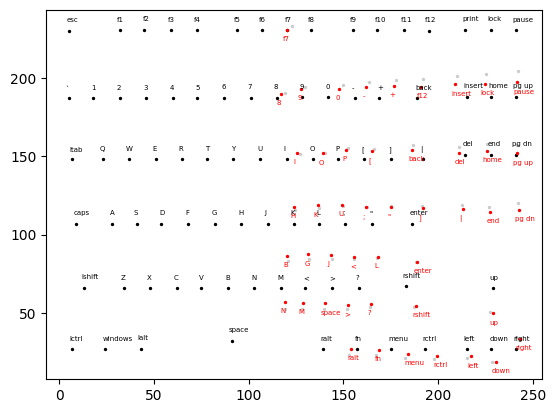

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [210]:
ax = texcoords.scatter()
scatter(palette.colors, ax=ax, color="black")
scatter(result, ax=ax, color="red")

for (u, v), cls in palette.colors_to_name.items():
    ax.text(u - 2, v + 5, cls, c="black", fontsize=5)
    
for (u, v), cls in zip(result, keys):
    ax.text(u - 2, v - 7, cls, c="red", fontsize=5)

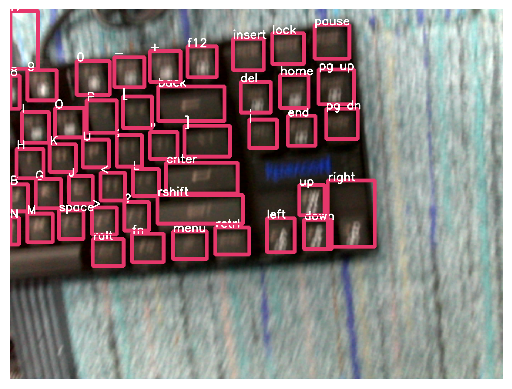

In [218]:
scale = 3

img = bboxes.orig_img.copy()
width, height, _ = img.shape
img = cv2.resize(img, (height * scale, width * scale))
boxes = [LabeledBBox(*box.xywh[0], label).scale(scale) for box, label in zip(bboxes.boxes, keys)]

plot_bboxes(img, boxes)